In [21]:
import os
# 训练，测试集的路径
train_cat_dir = os.path.join('./data/train/cat')
train_dog_dir = os.path.join('./data/train/dog')
validation_cat_dir = os.path.join('./data/test/cat')
validation_dog_dir = os.path.join('./data/test/dog')

In [22]:
# 看几张图片的名称
train_cat_names = os.listdir(train_cat_dir)
print(train_cat_names[:3])
train_dog_names = os.listdir(train_dog_dir)
print(train_dog_names[:3])
validation_cat_hames = os.listdir(validation_cat_dir)
print(validation_cat_hames[:3])
validation_dog_names = os.listdir(validation_dog_dir)
print(validation_dog_names[:3])

['cat.10134.tif', 'cat.9985.tif', 'cat.12195.tif']
['dog.10643.tif', 'dog.7524.tif', 'dog.1686.tif']
['cat.935.tif', 'cat.869.tif', 'cat.919.tif']
['dog.862.tif', 'dog.134.tif', 'dog.443.tif']


In [23]:
# 看训练，测试集中猫和狗的图片分别有多少张
print('total training cat images:', len(os.listdir(train_cat_dir)))
print('total training dog images:', len(os.listdir(train_dog_dir)))
print('total validation cat images:', len(os.listdir(validation_cat_dir)))
print('total validation dog images:', len(os.listdir(validation_dog_dir)))

total training cat images: 11500
total training dog images: 11500
total validation cat images: 1000
total validation dog images: 1000


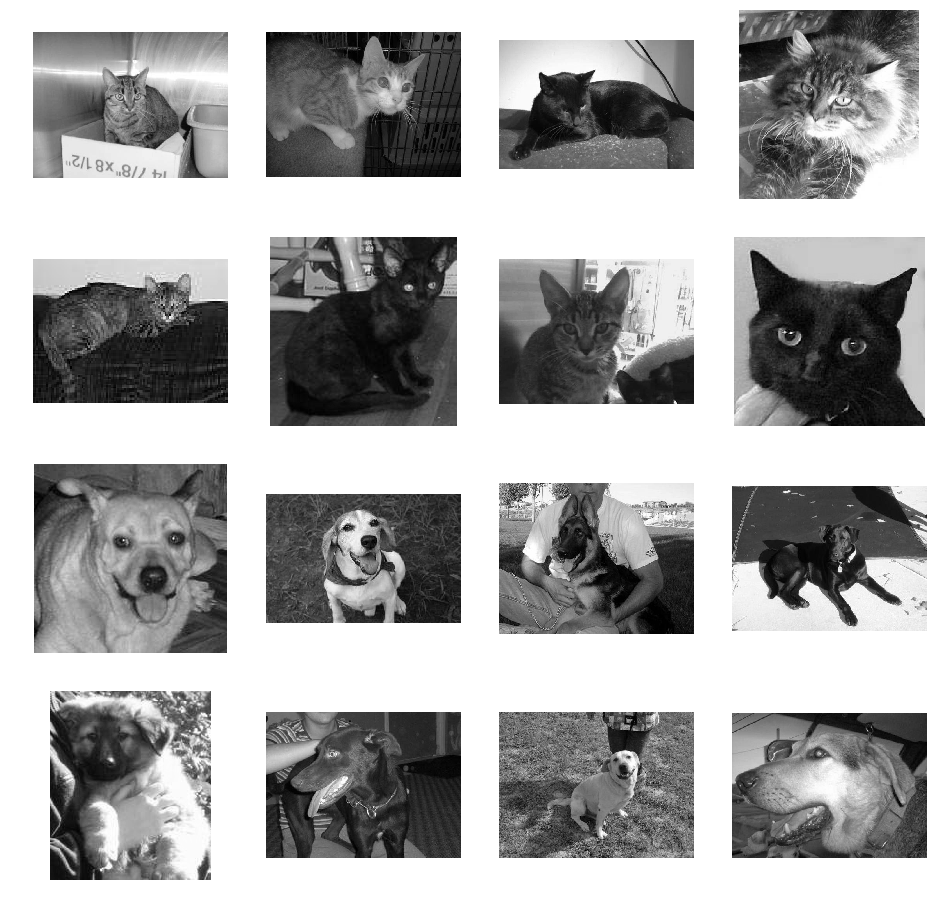

In [24]:
# 看看这些图片长什么样
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 作图用到的参数,我们生成4x4张图片
nrows = 4
ncols = 4

# 一个迭代图片用到的参数
pic_index = 0

# 初始化 matplotlib 图片, 设置大小
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cat_dir, fname) 
                for fname in train_cat_names[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dog_dir, fname) 
                for fname in train_dog_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # 设置子图; 子图索引从 1　开始
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # 不显示坐标

  img = mpimg.imread(img_path)
  plt.imshow(img,cmap='gray')
plt.show()

In [25]:
# 看其中一张图片的内容
img, img.shape

(array([[96, 97, 99, ..., 44, 44, 44],
        [95, 96, 98, ..., 46, 46, 46],
        [98, 98, 98, ..., 47, 47, 47],
        ...,
        [69, 71, 72, ..., 89, 68, 62],
        [69, 71, 72, ..., 92, 70, 63],
        [70, 72, 73, ..., 91, 73, 69]], dtype=uint8), (374, 500))

In [26]:
# 为了训练神经网络我们需要对真实的图片数据做预处理
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 将所有的图片做归一化的处理，灰度图像素值的大小是从0~255,归一化后是从0~1
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 使用 train_datagen 生成器遍历训练数据
train_generator = train_datagen.flow_from_directory(
        './data/train/',  # 训练数据目录
        target_size=(300, 300),  # 将所有的图片调整大小到 300x300，这样不论原始图片的大小为多少都没有问题
        batch_size=32,
        # 由于我们有多个输出，我们这里定义是categorical分类模式
        class_mode='categorical',
        color_mode='grayscale')

# Flow training images in batches of 32 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        './data/test/',  # This is the source directory for validation images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        class_mode='categorical',
        color_mode='grayscale')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [27]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

In [28]:
tf.__version__

'1.9.0'

In [29]:
# 定义卷积神经网络模型
def create_model():
    model = tf.keras.models.Sequential([
        # 这里使用的是灰度图片，只有一个通道，大小是300x300
        # 第一个卷积层
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # 第二个卷积层
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # 第三个卷积层
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # 第四个卷积层
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # 第六个卷积层
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(), # 这里使用全局平局池化的目的是为了显示CAM图
        # 输出层
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    
    # 定义损失函数,优化器,学习率等
    model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])
    
    return model

In [30]:
# 创建模型
model = create_model()

In [31]:
# 查看模型的参数
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 16)      160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 33, 128)       73856     
__________

In [34]:
# 训练模型
# 训练过程1
history = model.fit_generator(
      train_generator,
      steps_per_epoch=718,  
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=62) 

Epoch 1/10
718/718 [==============================] - 82s 114ms/step - loss: 0.5821 - acc: 0.6994 - val_loss: 0.5386 - val_acc: 0.7263
Epoch 2/10
718/718 [==============================] - 82s 114ms/step - loss: 0.5352 - acc: 0.7417 - val_loss: 0.4695 - val_acc: 0.7918
Epoch 3/10
718/718 [==============================] - 82s 114ms/step - loss: 0.4875 - acc: 0.7723 - val_loss: 0.6002 - val_acc: 0.7193
Epoch 4/10
718/718 [==============================] - 82s 114ms/step - loss: 0.4395 - acc: 0.7998 - val_loss: 0.3590 - val_acc: 0.8438
Epoch 5/10
718/718 [==============================] - 82s 114ms/step - loss: 0.4012 - acc: 0.8235 - val_loss: 0.3616 - val_acc: 0.8523
Epoch 6/10
718/718 [==============================] - 82s 115ms/step - loss: 0.3706 - acc: 0.8408 - val_loss: 0.3045 - val_acc: 0.8755
Epoch 7/10
718/718 [==============================] - 82s 114ms/step - loss: 0.3336 - acc: 0.8603 - val_loss: 0.3672 - val_acc: 0.8286
Epoch 8/10
718/718 [==============================] - 8

In [35]:
# 训练过程2
history2 = model.fit_generator(
      train_generator,
      steps_per_epoch=718,  
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=62) 

Epoch 1/10
718/718 [==============================] - 83s 116ms/step - loss: 0.2394 - acc: 0.9019 - val_loss: 0.2220 - val_acc: 0.9047
Epoch 2/10
718/718 [==============================] - 83s 115ms/step - loss: 0.2182 - acc: 0.9125 - val_loss: 0.1924 - val_acc: 0.9194
Epoch 3/10
718/718 [==============================] - 82s 114ms/step - loss: 0.2072 - acc: 0.9166 - val_loss: 0.2159 - val_acc: 0.9189
Epoch 4/10
718/718 [==============================] - 82s 114ms/step - loss: 0.1920 - acc: 0.9227 - val_loss: 0.1823 - val_acc: 0.9269
Epoch 5/10
718/718 [==============================] - 82s 114ms/step - loss: 0.1796 - acc: 0.9292 - val_loss: 0.1876 - val_acc: 0.9254
Epoch 6/10
718/718 [==============================] - 82s 114ms/step - loss: 0.1698 - acc: 0.9333 - val_loss: 0.2347 - val_acc: 0.9052
Epoch 7/10
718/718 [==============================] - 82s 114ms/step - loss: 0.1612 - acc: 0.9373 - val_loss: 0.1831 - val_acc: 0.9254
Epoch 8/10
718/718 [==============================] - 8

In [36]:
# 训练过程3
history3 = model.fit_generator(
      train_generator,
      steps_per_epoch=718,  
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=62) 

Epoch 1/10
718/718 [==============================] - 82s 115ms/step - loss: 0.1341 - acc: 0.9469 - val_loss: 0.2066 - val_acc: 0.9345
Epoch 2/10
718/718 [==============================] - 83s 115ms/step - loss: 0.1284 - acc: 0.9492 - val_loss: 0.1919 - val_acc: 0.9380
Epoch 3/10
718/718 [==============================] - 82s 115ms/step - loss: 0.1213 - acc: 0.9527 - val_loss: 0.3798 - val_acc: 0.8987
Epoch 4/10
718/718 [==============================] - 82s 115ms/step - loss: 0.1192 - acc: 0.9569 - val_loss: 0.2496 - val_acc: 0.9219
Epoch 5/10
718/718 [==============================] - 82s 114ms/step - loss: 0.1089 - acc: 0.9574 - val_loss: 0.2344 - val_acc: 0.9415
Epoch 6/10
718/718 [==============================] - 83s 116ms/step - loss: 0.1173 - acc: 0.9598 - val_loss: 0.1693 - val_acc: 0.9390
Epoch 7/10
718/718 [==============================] - 84s 117ms/step - loss: 0.1044 - acc: 0.9612 - val_loss: 0.2256 - val_acc: 0.9168
Epoch 8/10
718/718 [==============================] - 8

In [37]:
# 训练过程4
history4 = model.fit_generator(
      train_generator,
      steps_per_epoch=718,  
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=62) 

Epoch 1/10
718/718 [==============================] - 84s 118ms/step - loss: 0.0987 - acc: 0.9656 - val_loss: 0.2526 - val_acc: 0.9430
Epoch 2/10
718/718 [==============================] - 83s 115ms/step - loss: 0.0966 - acc: 0.9661 - val_loss: 0.3252 - val_acc: 0.9325
Epoch 3/10
718/718 [==============================] - 83s 115ms/step - loss: 0.1000 - acc: 0.9658 - val_loss: 0.2742 - val_acc: 0.9249
Epoch 4/10
718/718 [==============================] - 82s 115ms/step - loss: 0.0931 - acc: 0.9671 - val_loss: 0.1872 - val_acc: 0.9304
Epoch 5/10
718/718 [==============================] - 83s 116ms/step - loss: 0.0946 - acc: 0.9693 - val_loss: 0.2520 - val_acc: 0.9370
Epoch 6/10
718/718 [==============================] - 83s 115ms/step - loss: 0.0937 - acc: 0.9684 - val_loss: 0.2035 - val_acc: 0.9340
Epoch 7/10
718/718 [==============================] - 85s 118ms/step - loss: 0.0932 - acc: 0.9701 - val_loss: 0.2047 - val_acc: 0.9446
Epoch 8/10
718/718 [==============================] - 8

In [38]:
# 通过40个Epoch神经网络在测试集上的准确率达到93%，接下来我们保存模型
model.save('cat_dog_cam_classifier.h5')